# Angular focus stacking experiment - II

In [1]:
from __future__ import print_function, division
import numpy as np
import collections as co
import iutils.cv.transforms as cvt
import iutils.optics.goptics as gou
import os.path as osp
# import Christoph Gholke's tifffile module
import iutils.image.tifffile.tifffile as tf
from scipy.misc import imread, imsave
import matplotlib.pyplot as plt

# constants
pi = np.pi

# trig functions
sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))
arcsind = lambda x : np.rad2deg(np.arcsin(x))
arctand = lambda x : np.rad2deg(np.arctan(x))

In [2]:
%precision 2

u'%.2f'

## Test COP shift compensation

In [3]:
# cop compensation  

def get_COP_shift_compensation(alpha, hy, hz):
    """returns the amount of compensation required to restore the COP following
    a rotation of the lens about a pivot point away from the COP
    
    Parameters
    ----------
    alpha : real
        angle of rotation of the lens about x-axis in degrees
    hy : real
        y component of the distance of the COP from the pivot 
    hz : real 
        z component of the distance of the COP from the pivot
    """
    shiftYZ = co.namedtuple('comp', ['delY', 'delZ'])
    # shiftY, shiftZ are the shift of the COP along the y and z directions
    shiftY = -hz*sind(alpha) + hy*(1 - cosd(alpha))
    shiftZ = -hy*sind(alpha) - hz*(1 - cosd(alpha))
    return shiftYZ(-shiftY, -shiftZ)

## Focusing on tilted plane

In [4]:
#  helper f
def compute_zoDash(zo, f, mp, d, alpha):
    """formula for computing the image plane distance from the pivot (origin of {C}) if
    lens is tilted about the ENPP. That is de=0, deDash = d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: d: distance from ENPP to EXPP
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    """
    c = cosd(alpha)
    s = sind(alpha)
    return d*c + mp*f*zo*(mp*c**2 + s**2)/(zo*mp*c + f)

def compute_beta(zo, f, mp, alpha):
    """formula for computing the object plane tilt angle if
    lens is tilted about the ENPP. That is de=0, deDash = d
    
    @param: zo: object distance along z-axis
    @param: f: focal length
    @param: mp: pupil magnification
    @param: alpha: angle of image plane tilt about x-axis (in degrees)
    """
    c = cosd(alpha)
    s = sind(alpha)
    t = -s*(mp*zo + (1-mp)*f*c)/(f*(mp*c**2 + s**2))
    return arctand(t)

In [5]:
# Iterative algorithm to find alpha, given beta

def g_of_alpha_is_monotonic(zo, f, mp):
    """test (method 2) to see if first derivative has real roots
    
    Note:
    -----
    The test for monotonicity using D is only relevant if mp < 1.
    """
    if mp == 1:
        D = 1  # the equation is linear
    else:
        a = 1
        b = f*(1 + mp)/(mp*zo)
        c = -(1 - 2*mp)/(1 - mp)
        d = -f/(mp*zo)
        Q = c/(3.0*a) - b**2/(9.0*a**2)
        R = -b**3/(27.0*a**3) + b*c/(6.0*a**2) - d/(2.0*a)
        D = Q**3 + R**2
    monotonicity = D > 0 if mp < 1 else True
    return monotonicity, D

def alpha_thin(zo, f, beta):
    return -arcsind(f*tand(beta)/zo)

def get_step(err):
    return 0.5*err

def estimate_alpha(zo, f, mp, beta, maxSteps=250, maxError=1e-16, retSteps=False):
    """iterative method to estimate alpha given beta and other parameters
    """
    assert g_of_alpha_is_monotonic(zo, f, mp)[0], 'g(alpha) is not monotonic'
    i = 0
    t = tand(beta)
    alphaInit = alpha_thin(zo=zo, f=f, beta=beta)
    s = sind(alphaInit)
    c = cosd(alphaInit)
    err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2)) # Initial merit function value
    prevErr = 0
    alpha_i = alphaInit
    deltaStep = get_step(err)  # deltaErr = err - prevErr = err
    if retSteps:
        alphas, errors, steps = [], [], []
        alphas.append(alphaInit)
        errors.append(err)
        steps.append(deltaStep)
    # begin iteration
    while (abs(err) > maxError) and (i < maxSteps):
        i += 1
        alpha_i += deltaStep
        prevErr = err
        s = sind(alpha_i)
        c = cosd(alpha_i)
        err = t + s*(mp*zo + f*(1-mp)*c)/(f*(mp*c**2 + s**2))
        if err*prevErr < 0:  # if error changes sign
            deltaErr = err - prevErr
            deltaStep = get_step(deltaErr)
        if retSteps:
            alphas.append(alpha_i)
            errors.append(err)
            steps.append(deltaStep)
    # end of iteration ----
    if retSteps:
        return alpha_i, i, err, alphas, errors, steps
    else:
        return alpha_i, i, err

In [18]:
# Optical system
mp = 1.0 
f = 180.0
lensOffset = -8.0
zo_far = -4038.6 + lensOffset      # -159 inch
zo_near = -2819.4 + lensOffset
zo_middle = -3429.0  + lensOffset  # -135 inch  

In [19]:
zo_near

-2827.40

A method to determine $d$ is from the transverse magnification $m_t$ (assuming $m_p\approx 1$):

$$
m_t = \frac{\acute{z}_o - d}{z_o}
$$


where, $z_o$ is the distance of the object plane from the center of the entrance pupil, and $\acute{z}_o$ is distance of the image plane from the center of the entrance pupil.


Based on several observations on the middle plane, I found $m_t$ to be equal to $0.046$.  Accordingly, $d=-5$ mm


### Data collection  

In [17]:
alphas = [-14.0, -14.3, -14.7, -15, -15.3, -15.7, -16, -16.3, -16.7, -17, -17.3, -17.7, -18, -18.3, -18.7, -19]

hz = 32
hy = -10
for alpha in alphas:
    delyz = get_COP_shift_compensation(alpha=alpha, hy=hy, hz=hz)
    print('alpha = {:2.1f}, dely = {:2.2f}, delz = {:2.2f}'.format(alpha, delyz.delY, delyz.delZ))


alpha = -14.0, dely = -7.44, delz = 3.37
alpha = -14.3, dely = -7.59, delz = 3.46
alpha = -14.7, dely = -7.79, delz = 3.59
alpha = -15.0, dely = -7.94, delz = 3.68
alpha = -15.3, dely = -8.09, delz = 3.77
alpha = -15.7, dely = -8.29, delz = 3.90
alpha = -16.0, dely = -8.43, delz = 4.00
alpha = -16.3, dely = -8.58, delz = 4.09
alpha = -16.7, dely = -8.77, delz = 4.22
alpha = -17.0, dely = -8.92, delz = 4.32
alpha = -17.3, dely = -9.06, delz = 4.42
alpha = -17.7, dely = -9.26, delz = 4.56
alpha = -18.0, dely = -9.40, delz = 4.66
alpha = -18.3, dely = -9.54, delz = 4.76
alpha = -18.7, dely = -9.73, delz = 4.90
alpha = -19.0, dely = -9.87, delz = 5.00


In [62]:
beta = compute_beta(zo_far, f, mp, alpha=-19)
betaDash = 90 + beta   # angle above the horizontal line
print('beta =', beta)
print('betaDash =', betaDash)

beta = -83.2168293071
betaDash = 6.7831706929


In [8]:
1.0/3

0.33

In [9]:
d = -5.0
compute_zoDash(zo_far-7000, f, mp, d, alpha=-19)

188.98

In [51]:
zo_near

-3429.00

In [8]:
mp = 1.0 
d = -8.0
f = 180.0
#zo = -4038.6  # 159 inch 
zo = -4648.2

In [9]:
compute_beta(zo, f, mp, alpha=-19)

-83.22

### Theoretical inter-image homography

In [20]:
import sympy as sy
sy.init_printing(use_latex='mathjax', print_builtin=False)

In [21]:
alpha1 = sy.symbols('alpha_1', real=True)
alpha2 = sy.symbols('alpha_2', real=True)
d = sy.symbols('d', real=True)                 # distance of the exit pupil from the entrance pupil.
p = sy.symbols('p', real=True, positive=True)  # pixel size
zoD = sy.symbols("z'_o", real=True)

In [22]:
A1 = sy.Matrix((( (zoD - d*sy.cos(alpha1))/p,            0,                    0               ), 
                (       0,                    (zoD - d*sy.cos(alpha1))/p,   -d*sy.sin(alpha1)/p),
                (       0,                              0,                     1               )     
               ))

In [23]:
A1

⎡-d⋅cos(α₁) + z'ₒ                               ⎤
⎢────────────────         0               0     ⎥
⎢       p                                       ⎥
⎢                                               ⎥
⎢                  -d⋅cos(α₁) + z'ₒ  -d⋅sin(α₁) ⎥
⎢       0          ────────────────  ───────────⎥
⎢                         p               p     ⎥
⎢                                               ⎥
⎣       0                 0               1     ⎦

In [24]:
A2 = sy.Matrix((( (zoD - d*sy.cos(alpha2))/p,            0,                       0           ), 
                (      0,                    (zoD - d*sy.cos(alpha2))/p,   -d*sy.sin(alpha2)/p),
                (      0,                                0,                       1           )     
               ))

In [25]:
A2

⎡-d⋅cos(α₂) + z'ₒ                               ⎤
⎢────────────────         0               0     ⎥
⎢       p                                       ⎥
⎢                                               ⎥
⎢                  -d⋅cos(α₂) + z'ₒ  -d⋅sin(α₂) ⎥
⎢       0          ────────────────  ───────────⎥
⎢                         p               p     ⎥
⎢                                               ⎥
⎣       0                 0               1     ⎦

In [26]:
A2.inv()

⎡       p                                            ⎤
⎢────────────────         0                 0        ⎥
⎢-d⋅cos(α₂) + z'ₒ                                    ⎥
⎢                                                    ⎥
⎢                         p             d⋅sin(α₂)    ⎥
⎢       0          ────────────────  ────────────────⎥
⎢                  -d⋅cos(α₂) + z'ₒ  -d⋅cos(α₂) + z'ₒ⎥
⎢                                                    ⎥
⎣       0                 0                 1        ⎦

In [27]:
H21 = A2*A1.inv()

In [28]:
H21

⎡-d⋅cos(α₂) + z'ₒ                                                             
⎢────────────────         0                              0                    
⎢-d⋅cos(α₁) + z'ₒ                                                             
⎢                                                                             
⎢                  -d⋅cos(α₂) + z'ₒ    d⋅sin(α₂)   d⋅(-d⋅cos(α₂) + z'ₒ)⋅sin(α₁
⎢       0          ────────────────  - ───────── + ───────────────────────────
⎢                  -d⋅cos(α₁) + z'ₒ        p           p⋅(-d⋅cos(α₁) + z'ₒ)   
⎢                                                                             
⎣       0                 0                              1                    

 ⎤
 ⎥
 ⎥
 ⎥
)⎥
─⎥
 ⎥
 ⎥
 ⎦

The above expression is:
$$
H(\alpha_2, \alpha_1) = 
\left[\begin{matrix}\frac{d \cos{\left (\alpha_{2} \right )} - z'_{o}}{d \cos{\left (\alpha_{1} \right )} - z'_{o}} & 0 & 0\\0 & \frac{d \cos{\left (\alpha_{2} \right )} - z'_{o}}{d \cos{\left (\alpha_{1} \right )} - z'_{o}} & \frac{d}{p \left(d \cos{\left (\alpha_{1} \right )} - z'_{o}\right)} \left(d \sin{\left (\alpha_{1} - \alpha_{2} \right )} - z'_{o} \sin{\left (\alpha_{1} \right )} + z'_{o} \sin{\left (\alpha_{2} \right )}\right)\\0 & 0 & 1\end{matrix}\right]
$$

In [29]:
H21.subs(alpha1, 0)

⎡-d⋅cos(α₂) + z'ₒ                               ⎤
⎢────────────────         0               0     ⎥
⎢    -d + z'ₒ                                   ⎥
⎢                                               ⎥
⎢                  -d⋅cos(α₂) + z'ₒ  -d⋅sin(α₂) ⎥
⎢       0          ────────────────  ───────────⎥
⎢                      -d + z'ₒ           p     ⎥
⎢                                               ⎥
⎣       0                 0               1     ⎦

In [30]:
H21

⎡-d⋅cos(α₂) + z'ₒ                                                             
⎢────────────────         0                              0                    
⎢-d⋅cos(α₁) + z'ₒ                                                             
⎢                                                                             
⎢                  -d⋅cos(α₂) + z'ₒ    d⋅sin(α₂)   d⋅(-d⋅cos(α₂) + z'ₒ)⋅sin(α₁
⎢       0          ────────────────  - ───────── + ───────────────────────────
⎢                  -d⋅cos(α₁) + z'ₒ        p           p⋅(-d⋅cos(α₁) + z'ₒ)   
⎢                                                                             
⎣       0                 0                              1                    

 ⎤
 ⎥
 ⎥
 ⎥
)⎥
─⎥
 ⎥
 ⎥
 ⎦

Reference image is with $\alpha = -14.7^o$

In [32]:
# homography between images -14.7° and -15.0° 
H21.evalf(subs={
         d: -5.0, 
         alpha1: np.deg2rad(-14.7), 
         alpha2: np.deg2rad(-15.0),
         zoD: 192.0,
         p: 0.006, 
        })

⎡0.999965912633428          0                  0        ⎤
⎢                                                       ⎥
⎢        0          0.999965912633428  -4.22479204816053⎥
⎢                                                       ⎥
⎣        0                  0                 1.0       ⎦

In [33]:
# homography between images -14.7° and -15.3° 
H21.evalf(subs={
         d: -5.0, 
         alpha1: np.deg2rad(-14.7), 
         alpha2: np.deg2rad(-15.3),
         zoD: 192.0,
         p: 0.006, 
        })

⎡0.999931152592679          0                  0        ⎤
⎢                                                       ⎥
⎢        0          0.999931152592679  -8.44381329761586⎥
⎢                                                       ⎥
⎣        0                  0                 1.0       ⎦

In [34]:
# homography between images -14.7° and -15.7° 
H21.evalf(subs={
         d: -5.0, 
         alpha1: np.deg2rad(-14.7), 
         alpha2: np.deg2rad(-15.7),
         zoD: 192.0,
         p: 0.006, 
        })

⎡0.999883761139378          0                  0        ⎤
⎢                                                       ⎥
⎢        0          0.999883761139378  -14.0599982711754⎥
⎢                                                       ⎥
⎣        0                  0                 1.0       ⎦

In [35]:
# homography between images -14.7° and -16.0° 
H21.evalf(subs={
         d: -5.0, 
         alpha1: np.deg2rad(-14.7), 
         alpha2: np.deg2rad(-16.0),
         zoD: 192.0,
         p: 0.006, 
        })

⎡0.999847435263344          0                  0        ⎤
⎢                                                       ⎥
⎢        0          0.999847435263344  -18.2651047884862⎥
⎢                                                       ⎥
⎣        0                  0                 1.0       ⎦

In [36]:
# homography between images -14.7° and -19.0° 
H21.evalf(subs={
         d: -5.0, 
         alpha1: np.deg2rad(-14.7), 
         alpha2: np.deg2rad(-19.0),
         zoD: 192.0,
         p: 0.006, 
        })

⎡0.99944753145397         0                  0        ⎤
⎢                                                     ⎥
⎢       0          0.99944753145397  -59.9586692958662⎥
⎢                                                     ⎥
⎣       0                 0                 1.0       ⎦

### Process the images

#### Creation of composite image

In [37]:
from __future__ import print_function, division
import os
import gc
import cv2
import numpy as np
import iutils.image.general as ig
from scipy.misc import imread, imsave
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive

In [38]:
%matplotlib inline

In [39]:
imgDir = "C:\\thesis_images"
# registered images
regImgDir = os.path.join(imgDir, 'fstack2_registered')

In [40]:
# application of LoG or Energy of Laplacian

def focal_measure(img, method='LoG', sigma=2, morpho=0, mkern_size=5):
    """returns the focal measure within a frame
    
       @method : 'LoG', 'LoGE', 'LAP', 'LAPE'
       @sigma : standard-deviation for Gaussian filter in LoG and LoGE
       @morpho : 0=no morphological operations, 1=dilation only, 2=closing
       @mkern_size : kernel size of morphological operation
    """
    
    assert method in ('LoG', 'LoGE', 'LAP', 'LAPE'), 'Invalid method'
    
    # weights for combining the color channels
    wt_r, wt_g, wt_b = 1.0/3, 1.0/3, 1.0/3

    if method == 'LoG' or method == 'LoGE':
        _filter = ndi.gaussian_laplace
    elif method == 'LAP' or method == 'LAPE':
        _filter = ndi.laplace
    
    # Ensure that the image data type is float 64
    img = img.astype('float64')    
    
    if method == 'LoG' or method == 'LoGE':  # Laplacian of Gaussian
        fm = (wt_r*np.abs(_filter(img[:,:, 0], sigma=sigma, truncate=5)) + 
              wt_g*np.abs(_filter(img[:,:, 1], sigma=sigma, truncate=5)) +
              wt_b*np.abs(_filter(img[:,:, 2], sigma=sigma, truncate=5)))
        if method == 'LoGE':
            fm = fm**2

    elif method == 'LAP' or method == 'LAPE':
        fm = (wt_r*np.abs(_filter(img[:,:, 0])) + 
              wt_g*np.abs(_filter(img[:,:, 1])) +
              wt_b*np.abs(_filter(img[:,:, 2])))
        
        if method == 'LAPE':  # Energy of Laplacian
            fm = fm/np.max(fm)
            fm = 255*fm**2

    # Morphological operation
    morpho_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                          (mkern_size, mkern_size))
    if morpho == 1:
        fm = cv2.morphologyEx(fm, cv2.MORPH_DILATE, morpho_kernel)
    elif morpho == 2:
        fm = cv2.morphologyEx(fm, cv2.MORPH_CLOSE, morpho_kernel)
    return fm

In [41]:
def show_focal_measure(focal_measure, colormap):
    fm_dict = {'LoG': fm_LoG, 'LoGE': fm_LoGE,'LAP': fm_LAP, 'LAPE': fm_LAPE}
    cmap_dict ={'magma': plt.cm.magma, 'virdis': plt.cm.viridis, 'plasma':plt.cm.plasma}
    img = fm_dict[focal_measure]
    #if focal_measure == 'LoG':  # only for display purpose
    #    img = img**1.5
    ig.imshow(image=img, figsize=(13, 9),  
              cmap=cmap_dict[colormap]);

In [42]:
regImgDir

'C:\\thesis_images\\fstack2_registered'

In [43]:
img = imread(regImgDir + '\\img7.png')

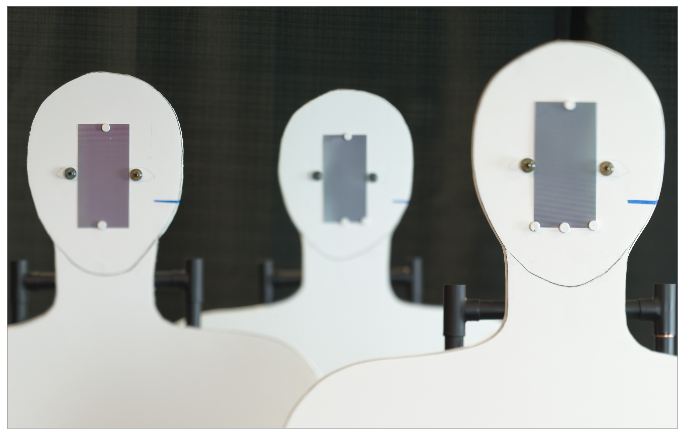

In [44]:
ig.imshow(img, figsize=(12, 8));

In [45]:
morpho = 1
sigma =  2
fm_LoG = focal_measure(img, method='LoG', sigma=sigma, morpho=morpho)
fm_LoGE = focal_measure(img, method='LoGE', sigma=sigma, morpho=morpho)
fm_LAP = focal_measure(img, method='LAP', morpho=morpho)
fm_LAPE = focal_measure(img, method='LAPE', morpho=morpho)

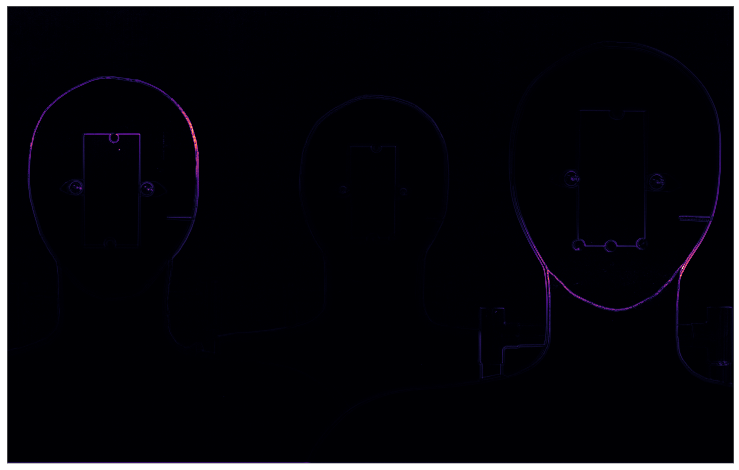

In [46]:
# display focal measures
v = interactive(show_focal_measure, 
                focal_measure=('LAP', 'LoG', 'LoGE', 'LAPE'), 
                colormap=('magma', 'virdis', 'plasma'))
display(v)

In [47]:
gc.collect()

12642

In [ ]:
# create stack and  (assumes that the images are already aligned)
# currently the the registered images are being collected from the 'fstack_registered' folder
gc.collect()
imgList = ig.get_imlist(filePath=regImgDir, itype='png')

morpho = 1
sigma = 2
#method = 'LAP'
method = 'LoG'
#method = 'LoGE'

# create focal_measure stack
#img_rgb_stack = [imread(image)[1090:1190,1650:1750,:] for image in imgList]  
img_rgb_stack = [imread(image) for image in imgList]  
fm_measure_stack = [focal_measure(img, method, sigma, morpho) for img in img_rgb_stack]
fm_measure_stack = np.dstack(fm_measure_stack)

In [49]:
# create composite
composite_img = np.zeros_like(img_rgb_stack[0])
fm_max_indices = np.argmax(fm_measure_stack, axis=2)
for index in range(len(imgList)):
    mask = fm_max_indices==index
    composite_img[:, :, 0] = composite_img[:, :, 0] + img_rgb_stack[index][:,:,0]*mask   
    composite_img[:, :, 1] = composite_img[:, :, 1] + img_rgb_stack[index][:,:,1]*mask   
    composite_img[:, :, 2] = composite_img[:, :, 2] + img_rgb_stack[index][:,:,2]*mask  

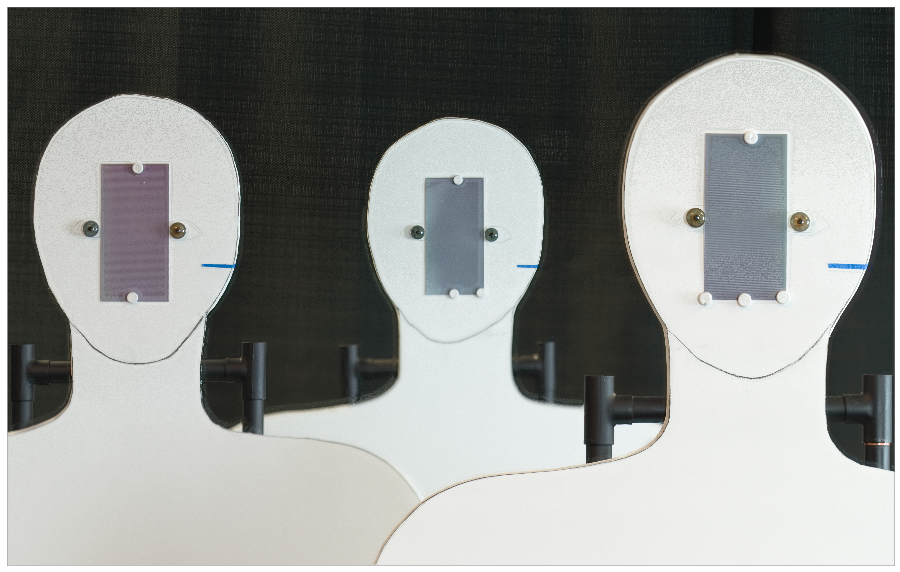

In [51]:
ig.imshow(image=composite_img, figsize=(16, 10));


compoImg = os.path.join(imgDir, 'composite2.png')
imsave(name=compoImg, arr=composite_img)

In [52]:
# focal measure of the composed image
fm_composite = focal_measure(composite_img, method='LoG', sigma=1, morpho=1)

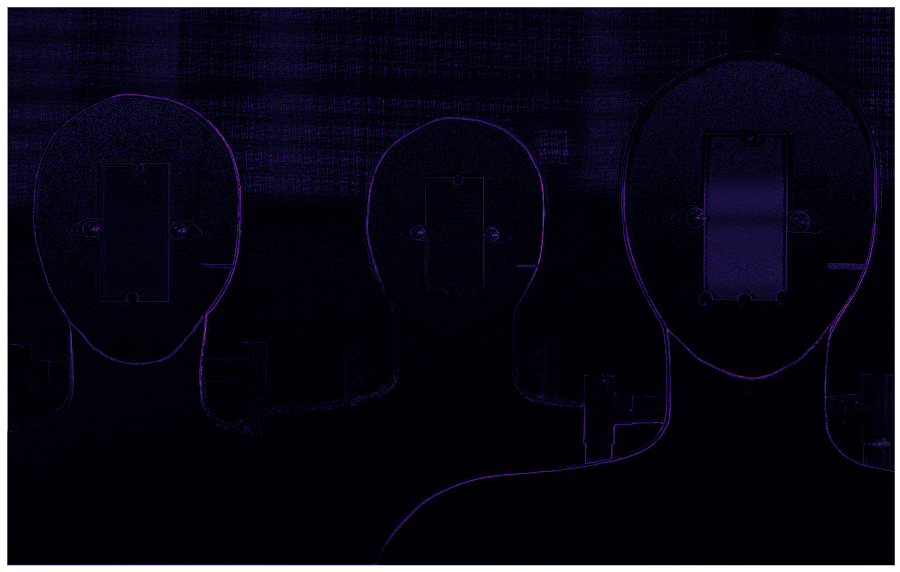

In [53]:
ig.imshow(image=fm_composite, figsize=(16, 10), cmap='magma');

In [68]:
gc.collect()

0

#### Focus measure of conventional image

In [73]:
cdir = os.getcwd()
imgName = os.path.join(cdir, 'images', 'conventional_f8.jpg')
cimg = imread(imgName)

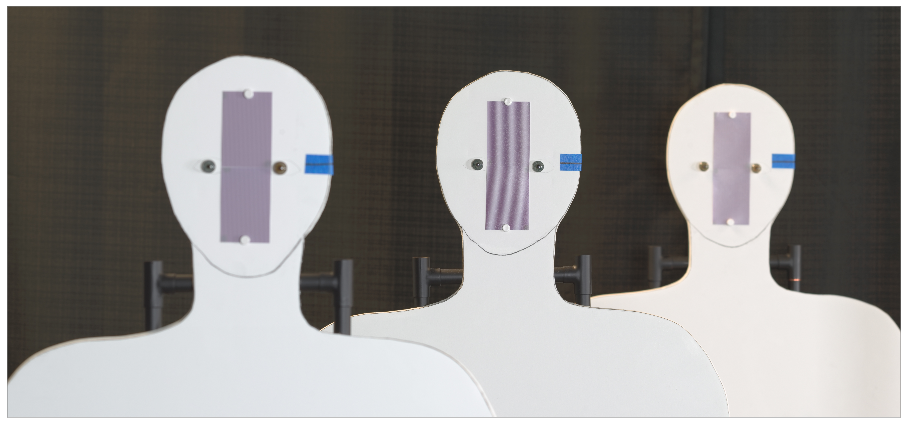

In [76]:
ig.imshow(image=cimg, figsize=(16, 10));

In [79]:
fm_cimg = focal_measure(cimg, method='LoG', sigma=1, morpho=1)

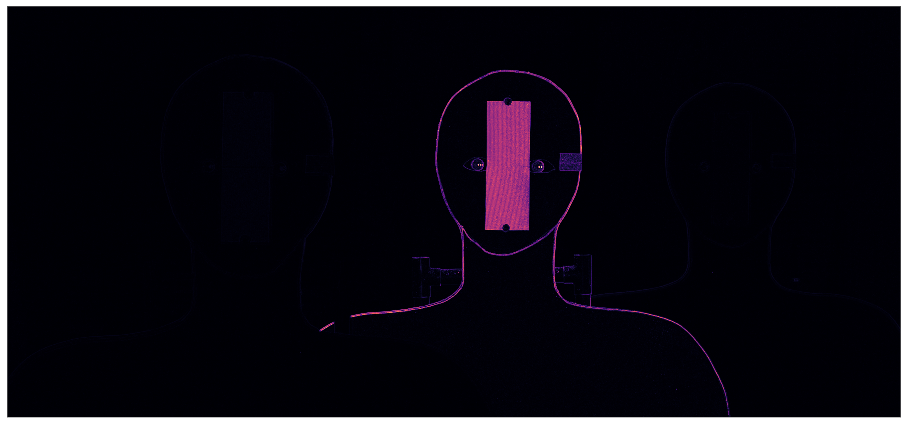

In [80]:
ig.imshow(image=fm_cimg, figsize=(16, 10), cmap='magma');